In [7]:
import pandas as pd
# Importing the data
DATA_PATH_GENRE = 'https://raw.githubusercontent.com/Spotify-Song-Predict-DS18/Song-Predict/main/data/data_w_genres.csv'
DATA_PATH_GENRE_2 = 'https://raw.githubusercontent.com/Spotify-Song-Predict-DS18/Song-Predict/main/data/data_by_genres.csv'
DATA_PATH_ARTIST = 'https://raw.githubusercontent.com/Spotify-Song-Predict-DS18/Song-Predict/main/data/data_by_artist.csv'
DATA_PATH = 'https://raw.githubusercontent.com/Spotify-Song-Predict-DS18/Song-Predict/main/data/data.csv'
genres = pd.read_csv(DATA_PATH_GENRE)
genre2 = pd.read_csv(DATA_PATH_GENRE_2)
artist = pd.read_csv(DATA_PATH_ARTIST)
control = pd.read_csv(DATA_PATH)

In [8]:
#CLEANING DATA: REMOVING '' and [] SYMBOLS

list_of_genres = []
for i in genres['genres']:
    i = i[1:-1].replace("'", "")
    list_of_genres.append(i)
    
genres.drop(['genres'], axis=1, inplace=True)
genres = genres.assign(New_genres=list_of_genres)
genres = genres.rename(columns={'New_genres':'genre', 'artists':'artist'})

#removing empty values from 'genre' column
genres = genres[genres['genre'] != '']

In [9]:
#CLEANING "ARTISTS": REMOVING [] and ''
list_of_artists  = []
for k in control['artists']:
    k = k[1:-1].replace("'", "")
    list_of_artists.append(k)
list_of_artists   
control.drop(['artists'], axis=1, inplace=True)
control = control.assign(New_artists=list_of_artists)
control = control.rename(columns={'New_artists':'artist'})

In [10]:
# Merging 
result = pd.merge(control, genres[['artist', 'genre']], how='left', on='artist')
result = result[result['genre'].isnull() == False]

In [11]:
# Transforming my dataset
# TODO - Dates need to be coherent
# TODO - might have to make it into a function. 

result['release_date'] = pd.to_datetime(result['release_date'])

In [12]:
# TODO - Build a recommender model with machine learning. 
from surprise import Reader, Dataset, SVD 
from surprise.model_selection.validation import cross_validate

# Intantiating my reader and my data
reader = Reader(rating_scale=(0,100))
data = Dataset.load_from_df(result[['artist', 'id', 'popularity']],
                           reader)
# Intatntiating my SVD 
svd = SVD()

In [13]:
# Running a 5-fold cross-validation 
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5,
              verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    13.5969 13.6508 13.6733 13.5575 13.5639 13.6085 0.0463  
MAE (testset)     10.8290 10.8623 10.8857 10.7859 10.7589 10.8244 0.0469  
Fit time          5.19    5.20    5.23    5.17    5.13    5.18    0.03    
Test time         0.10    0.22    0.20    0.24    0.10    0.17    0.06    


{'test_rmse': array([13.59689772, 13.65081067, 13.67328368, 13.55747887, 13.56394809]),
 'test_mae': array([10.82904306, 10.86228971, 10.88571653, 10.78586187, 10.75892419]),
 'fit_time': (5.186497926712036,
  5.203258275985718,
  5.231765985488892,
  5.170466899871826,
  5.128325462341309),
 'test_time': (0.10402321815490723,
  0.21504831314086914,
  0.20304489135742188,
  0.2400531768798828,
  0.09902215003967285)}

In [15]:
# Retraining the model using the entire dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

In [16]:
# Model has been trained, time to use for prediction.
titles = result.copy()

titles['Estimate_Score'] = titles['id'].apply(lambda x: svd.predict('Circles', x).est)

In [17]:
titles = titles.sort_values(by=['Estimate_Score'], ascending=False)
titles.head(10)

,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,...,name,popularity,release_date,speechiness,tempo,valence,year,artist,genre,Estimate_Score
126125,0.0217,0.755,202887,0.617,0,7na7Bk98usp84FaOJFPv3d,0.000000,9,0.0625,-5.144,...,Tattoo,89,2020-02-13,0.1820,193.896,0.745,2020,Rauw Alejandro,latin,38.815737
97637,0.1770,0.880,157606,0.751,0,2tnVG71enUj33Ic2nFN6kZ,0.000064,7,0.1060,-4.258,...,Ride It,90,2019-07-26,0.0874,117.948,0.884,2019,Regard,pop edm,38.796455
126050,0.2960,0.674,178480,0.881,0,5WHTFyqSii0lmT9R21abT8,0.000003,9,0.0793,-2.853,...,Don't Call Me Up,82,2019-01-18,0.1470,98.994,0.234,2019,Mabel,"dance pop, pop, post-teen pop, tropical house,...",38.718512
97781,0.0641,0.893,132453,0.579,1,68UU9oaQtMDnh6PRlW842H,0.000121,9,0.2150,-8.995,...,I Like Him,81,2020-02-26,0.1130,133.018,0.611,2020,Princess Nokia,"escape room, lgbtq+ hip hop, pop, trap queen",38.697055
97665,0.1770,0.866,223258,0.438,0,2W4yABdLc4Jnds67Poi5Nl,0.000000,7,0.0743,-8.943,...,Yellow Hearts,81,2019-06-18,0.0719,129.039,0.695,2019,Ant Saunders,pop,38.678754
126063,0.1270,0.700,182920,0.748,0,4cZ3UsiKd1kUQIaq4BFIj2,0.000000,1,0.0941,-6.044,...,No One Compares To You,77,2019-01-25,0.0434,111.939,0.631,2019,Jack & Jack,"dance pop, pop, post-teen pop, social media po...",38.647910
85144,0.1610,0.565,295533,0.564,0,0jWgAnTrNZmOGmqgvHhZEm,0.000000,2,0.1140,-10.044,...,What's Up?,78,1992-01-01,0.0292,134.355,0.454,1992,4 Non Blondes,"new wave pop, pop rock",38.620940
106941,0.1140,0.755,198040,0.536,0,33KJ2xFYONOlIYDBg6wPx8,0.000000,8,0.0282,-5.605,...,Personal,76,2017-11-30,0.1200,138.969,0.882,2017,HRVY,"dance pop, pop, post-teen pop, social media pop",38.619726
116709,0.1250,0.805,184255,0.562,0,4lMOQR1rRW5hJgJXOtKraL,0.000005,7,0.1480,-3.117,...,Relación,86,2020-04-02,0.1050,172.094,0.767,2020,Sech,"latin, panamanian pop, reggaeton",38.617852
87493,0.8050,0.398,253342,0.316,0,0tV8pOpiNsKqUys0ilUcXz,0.000000,1,0.2950,-7.031,...,Rise Up,76,2015-08-28,0.0368,118.582,0.174,2015,Andra Day,r&b,38.589404


In [29]:
# Visualize
import matplotlib.pyplot as plt
import numpy as np
from sklearn import neighbors, datasets
from category_encoders import OrdinalEncoder
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn import utils


enc = OrdinalEncoder()
titles['enc'] = enc.fit_transform(titles['artist'])






<ipython-input-35-103d6f99745d>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


KeyboardInterrupt: 

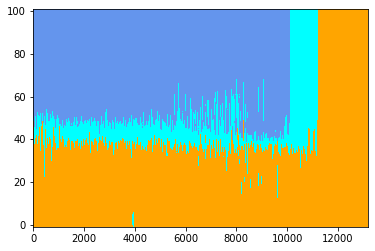

In [35]:
n_neighbors = 10

lab_enc = preprocessing.LabelEncoder()
x_data = titles[['enc', 'popularity']]
y_data = titles['Estimate_Score']

y = lab_enc.fit_transform(y_data)

h = 0.2

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(x_data, y)
    x_min, x_max = x_data['enc'].min() - 1, x_data['enc'].max() + 1
    y_min, y_max = x_data['popularity'].min() - 1, x_data['popularity'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    

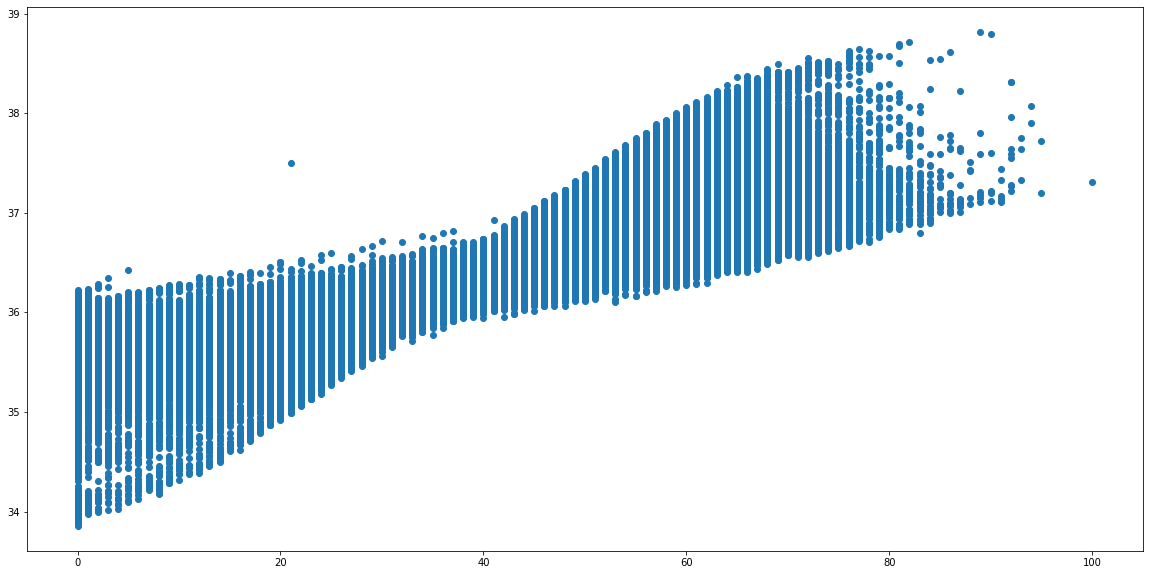

In [41]:
#GENERAL DISTRIBUTION

fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(titles['popularity'], titles['Estimate_Score'])
ax.grid(False)
plt.show();


In [56]:
pop = titles[titles['genre'].str.contains('pop', regex=False) == True]
rock = titles[titles['genre'].str.contains('rock', regex=False) == True]
metal = titles[titles['genre'].str.contains('metal', regex=False) == True]
jazz = titles[titles['genre'].str.contains('jazz', regex=False) == True]
hip_hop = titles[titles['genre'].str.contains('hop', regex=True) == True]
folk = titles[titles['genre'].str.contains('folk', regex=False) == True]
rap = titles[titles['genre'].str.contains('rap', regex=False) == True]
electro = titles[titles['genre'].str.contains('electro', regex=False) == True]
classic = titles[titles['genre'].str.contains('classic', regex=False) == True]
dnb = titles[titles['genre'].str.contains('drum and bass', regex=False) == True]

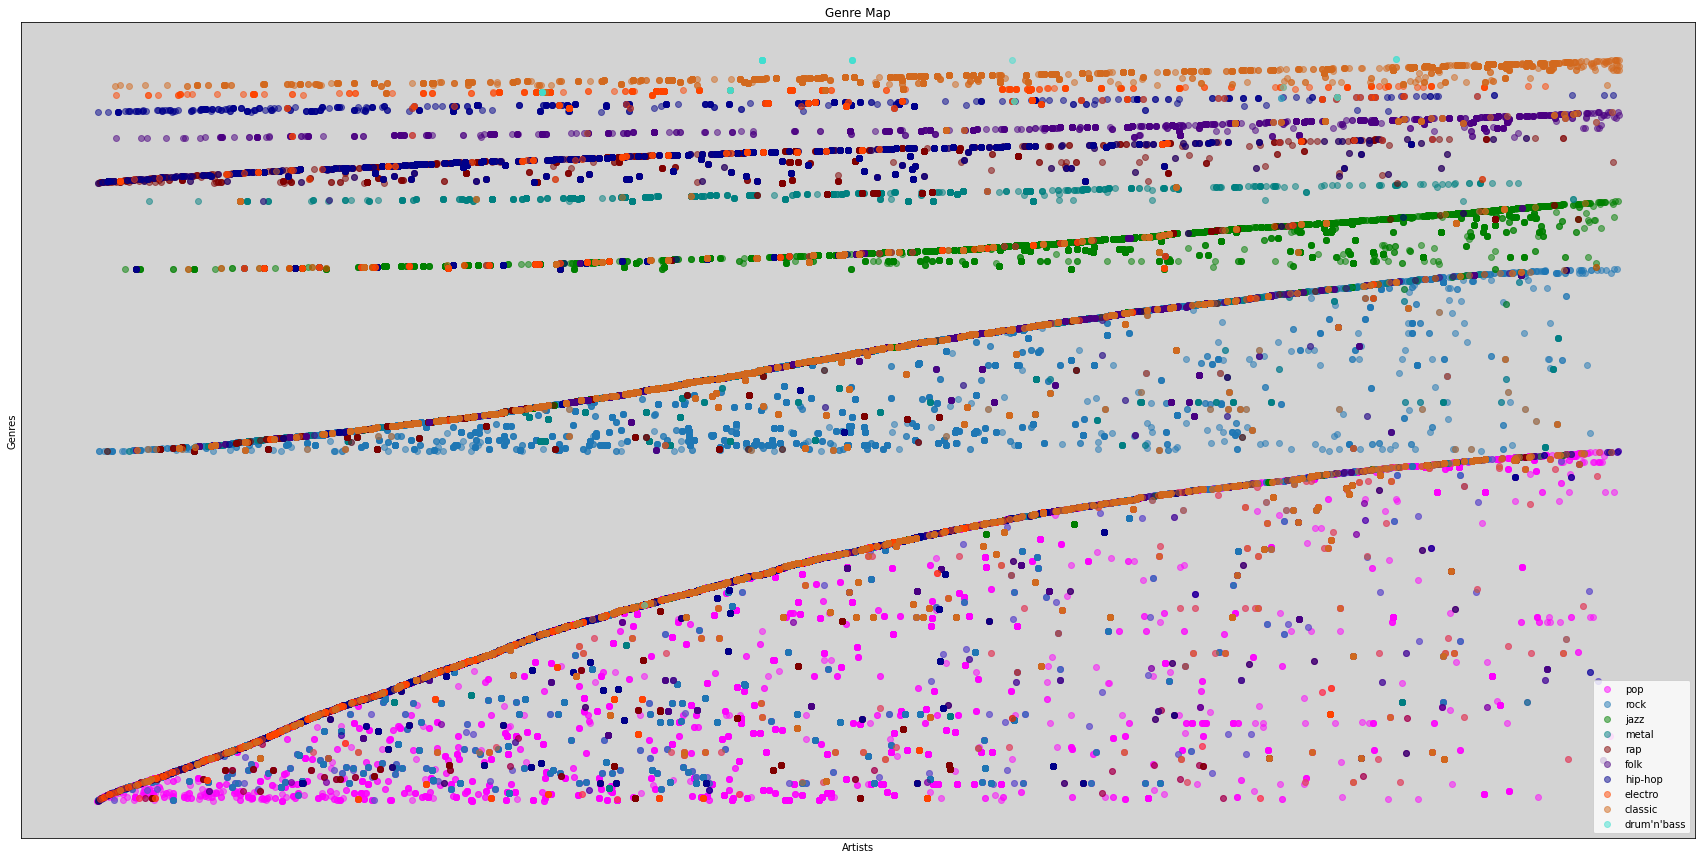

In [83]:
# PLOT BY GENRE
fig, ax = plt.subplots(figsize=(30, 15))

plt.title('Genre Map')
ax.set_facecolor('lightgray')
ax.scatter(pop['enc'], pop['genre'], color='magenta', alpha=0.5, label='pop')
ax.scatter(rock['enc'], rock['genre'],  alpha=0.5, label='rock')
ax.scatter(jazz['enc'], jazz['genre'], color='green',  alpha=0.5, label='jazz')
ax.scatter(metal['enc'], metal['genre'], color='teal',  alpha=0.5, label='metal')
ax.scatter(rap['enc'], rap['genre'], color='maroon',  alpha=0.5, label='rap')
ax.scatter(folk['enc'], folk['genre'], color='indigo',  alpha=0.5, label='folk')
ax.scatter(hip_hop['enc'], hip_hop['genre'], color='darkblue',  alpha=0.5, label='hip-hop')
ax.scatter(electro['enc'], electro['genre'], color='orangered',  alpha=0.5, label='electro')
ax.scatter(classic['enc'], classic['genre'], color='chocolate',  alpha=0.5, label='classic')
ax.scatter(dnb['enc'], dnb['genre'], color='turquoise',  alpha=0.5, label="drum'n'bass")

ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel("Genres")
ax.set_xlabel("Artists")
ax.legend()
plt.show();